Морфологический анализ <br/>
Домашнее задание 10 <br/>
**Голев Александр 135М**

# Обработать те же изображения, что и в задании 3, методом морфологического подавления шума по следующему алгоритму.

In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import product

import func as f
import mosaic_approx as ma
import old_denoiser as old

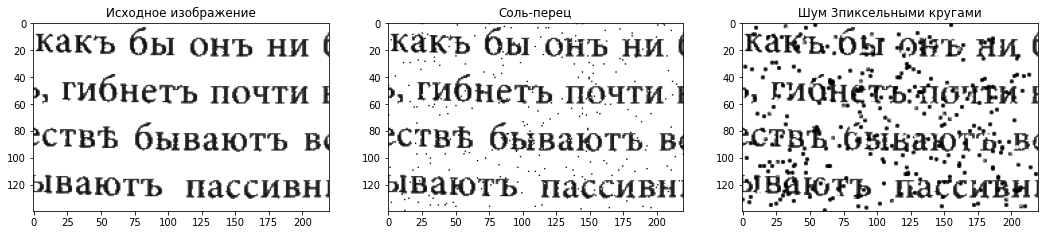

In [2]:
# Загружаем изображение
true_img,sp_img,crc_img = cv2.imread('text-d-true.png'),cv2.imread('text-d-sp.png'),cv2.imread('text-d-crc.png')
true_gray = cv2.cvtColor(true_img, cv2.COLOR_BGR2GRAY)
sp_gray= cv2.cvtColor(sp_img, cv2.COLOR_BGR2GRAY)
crc_gray = cv2.cvtColor(crc_img, cv2.COLOR_BGR2GRAY)

f.showOneLine([true_gray,sp_gray,crc_gray],['Исходное изображение','Соль-перец', 'Шум 3пиксельными кругами'] )

### 1. Обработать изображения, полученное из незашумленного изображения того же текста
 прибавлением нормально распределенного случайного шума с нулевым математическим ожиданием и дисперсией σ^2, где σ равно половине динамического диапазона изображения.

In [71]:
def add_sp(img,freq):
    assert freq <= 1 and freq >= 0
    mask = np.ones(img.shape)*255
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if random.random() < freq:
                img[i, j] = 0
                mask[i, j] = 0
    return img, mask

In [82]:
def add_crc(img,freq):
    assert freq <= 1 and freq >= 0
    mask = np.ones(img.shape)*255
    for i in range(1, img.shape[0]):
        for j in range(1, img.shape[1]):
            if random.random() < freq:
                img[i-1:i+2, j-1:j+2] = 128
                img[i, j-1:j+2] = 0
                img[i-1:i+2, j] = 0
                mask[i, j] = 0
    return img, mask

In [78]:
true_img = cv2.imread('text-d-true.png')
true_img = cv2.cvtColor(true_img, cv2.COLOR_BGR2GRAY)
true_img = true_img
true_img = true_img.astype(np.uint8)

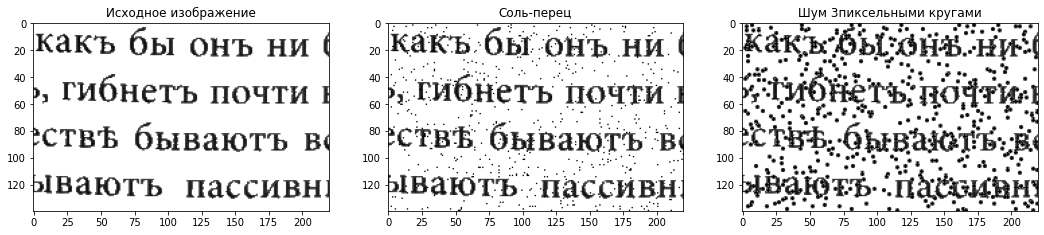

In [84]:
crc, map_crc = add_crc(true_img.copy(), 0.02)
sp, map_sp = add_sp(true_img.copy(), 0.02)
f.showOneLine([true_img,sp,crc],['Исходное изображение','Соль-перец', 'Шум 3пиксельными кругами'] )

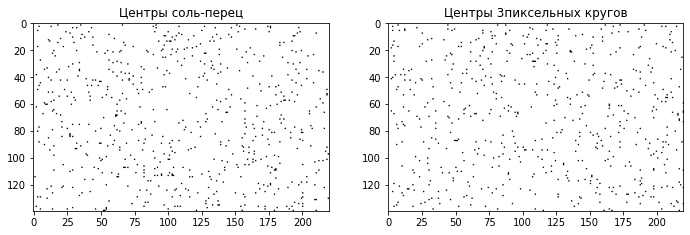

In [86]:
f.showOneLine([map_sp.astype(np.uint8),map_crc.astype(np.uint8)],['Центры соль-перец', 'Центры 3пиксельных кругов'] )

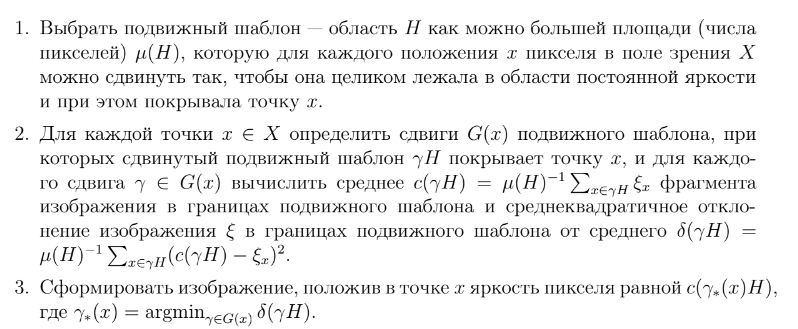
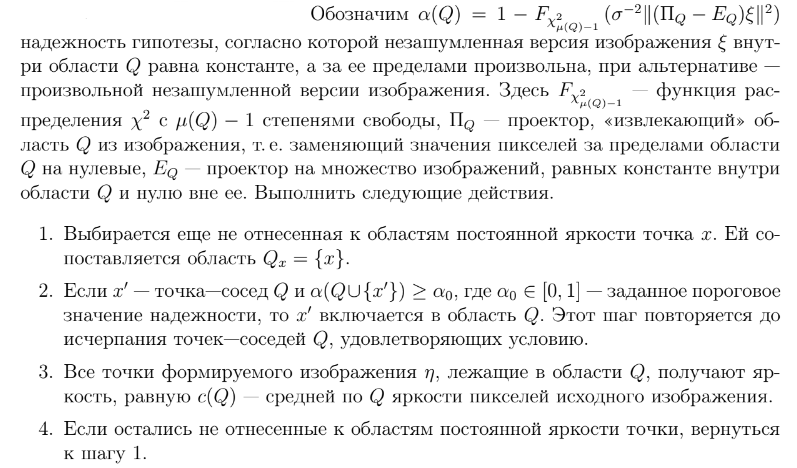
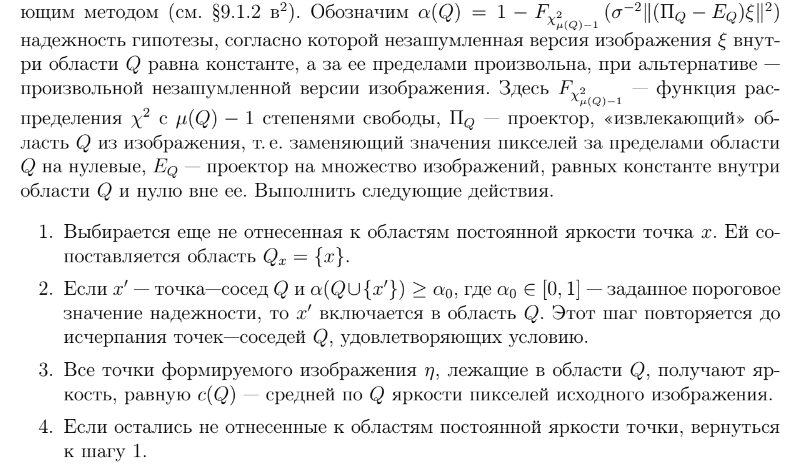

In [110]:
def horizontal_filter(img, f_size, direction):
  assert direction == 1 or direction == 0
  if direction == 0:
    return np.rot90(horizontal_filter(np.rot90(img), f_size, 1), k=3)
  H, W = img.shape
  # расширение границ
  img = np.pad(img, ((0,0), (f_size-1, f_size-1)))
  result = np.zeros((H, W))
  for y in range(0, H):
    for x in range(f_size-1, W+f_size-1):
      c_s = []
      delta_s = []
      #сдвигаем шаблон
      for i in range(f_size):
        area = img[y, x-(f_size-1)+i:x+1+i]
        #вычисляем среднее
        c = np.mean(area)
        c_s.append(c)
        temp = np.ones((1, f_size))*c
        #вычисляем среднеквадратичное отклонение
        delta  = np.mean(np.square(temp - area))
        delta_s.append(delta)
      #кладем в точку x argmin
      result[y, x - (f_size-1)] = c_s[np.argmin(delta_s)]
  result = result.astype(np.uint8)
  return result

Найдем оптимальный размер

In [115]:
best_shape, best_error = (0,0), 1
for i,j in product(range(1,6),repeat = 2):
    sp_clear = horizontal_filter(horizontal_filter(sp.copy(), i, direction=0), j, direction=1)
    error = old.mseImages(true_gray, sp_clear)
    if error< best_error:
        best_error = error
        best_shape = (i,j)
    print(f'({i},{j}) - {error}')

(1,1) - 0.008985091648067427
(1,2) - 0.0038148511811141564
(1,3) - 0.0039415374706032145
(1,4) - 0.009941874753466449
(1,5) - 0.01645605286677951
(2,1) - 0.003987697289254383
(2,2) - 0.0028678198195499238
(2,3) - 0.00370912910618793
(2,4) - 0.009125299959556016
(2,5) - 0.015406753396545785
(3,1) - 0.005261037463113588
(3,2) - 0.004957385770707569
(3,3) - 0.005886489462094998
(3,4) - 0.010784357165326023
(3,5) - 0.01718439910723648
(4,1) - 0.007989739960155185
(4,2) - 0.007843673012877165
(4,3) - 0.008856411869560658
(4,4) - 0.013552373213099857
(4,5) - 0.020379084218357574
(5,1) - 0.009670124377736835
(5,2) - 0.00960526570699581
(5,3) - 0.010557102912466235
(5,4) - 0.014815312042820694
(5,5) - 0.02188561567229387


In [116]:
sp_clear = horizontal_filter(horizontal_filter(sp.copy(), best_shape[0], direction=0), best_shape[1], direction=1)

sp_clear - 0.0028678198195499238
sp_dilated_comb - 0.006825840710615798


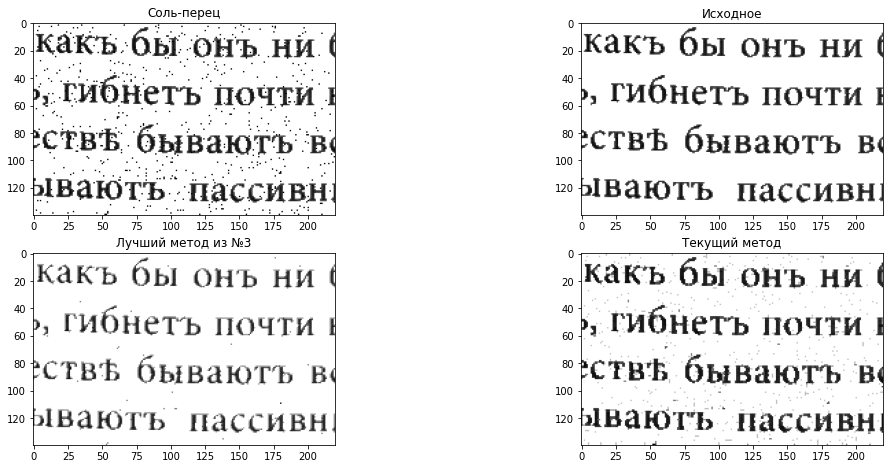

In [120]:
kernel_x = np.ones((1, 2), np.uint8) 
kernel_y = np.ones((2, 1), np.uint8)
sp_dilated_x, sp_dilated_y,sp_dilated_comb  = old.comboDilate(sp, kernel_x, kernel_y)

print('sp_clear -',old.mseImages(true_gray, sp_clear))
print('sp_dilated_comb -',old.mseImages(true_gray, sp_dilated_comb))

f.showOneLine([sp, true_gray, sp_dilated_comb, sp_clear],['Соль-перец','Исходное','Лучший метод из №3','Текущий метод'], dim = 2 )

Найдем оптимальный размер

In [122]:
best_shape, best_error = (0,0), 1
for i,j in product(range(1,6),repeat = 2):
    crc_clear = horizontal_filter(horizontal_filter(crc.copy(), i, direction=0), j, direction=1)
    error = old.mseImages(true_img, crc_clear)
    if error< best_error:
        best_error = error
        best_shape = (i,j)
    print(f'({i},{j}) - {error}')

(1,1) - 0.04610768360820264
(1,2) - 0.03604951666941287
(1,3) - 0.03650854291805849
(1,4) - 0.03161636783055468
(1,5) - 0.03274770043489767
(2,1) - 0.03628667670276667
(2,2) - 0.02949012642490152
(2,3) - 0.028286005382545176
(2,4) - 0.024202544475900874
(2,5) - 0.028370604213164768
(3,1) - 0.03739667560428806
(3,2) - 0.03227693294786721
(3,3) - 0.029689607144105415
(3,4) - 0.024944240726593663
(3,5) - 0.028888014100470847
(4,1) - 0.03022369942629458
(4,2) - 0.029674907752762422
(4,3) - 0.027660597073053822
(4,4) - 0.0237008433319852
(4,5) - 0.027343797091028924
(5,1) - 0.027388806502993353
(5,2) - 0.027186326437883535
(5,3) - 0.02561147935109873
(5,4) - 0.02289331775490945
(5,5) - 0.02680081437209465


In [123]:
crc_clear = horizontal_filter(horizontal_filter(crc.copy(), best_shape[0], direction=0), best_shape[1], direction=1)

crc_clear - 0.02289331775490945
crc_smoothed_image_b - 0.0585966993214398


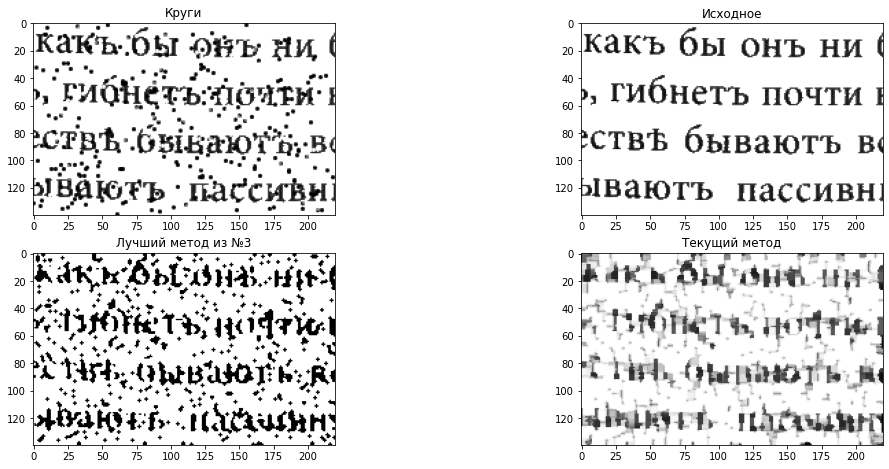

In [125]:
kernel_size_2 = (3, 3)

crc_smoothed_image = cv2.blur(crc, kernel_size_2)
_, crc_smoothed_image_b = cv2.threshold(crc_smoothed_image, 128, 255, cv2.THRESH_BINARY)

print('crc_clear -',old.mseImages(true_img, crc_clear))
print('crc_smoothed_image_b -',old.mseImages(true_img, crc_smoothed_image_b))

f.showOneLine([crc_gray, true_img, crc_smoothed_image_b, crc_clear],['Круги','Исходное','Лучший метод из №3','Текущий метод'], dim = 2)